In [1]:
import xgboost as xgb
import xarray as xr
import pandas as pd
import numpy as np
import gc
from flaml import AutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import logging 
import pickle
import seaborn as sns
# logging.disable(logging.CRITICAL)
# import shap

rc={'axes.labelsize': 15.0,
    'font.size': 15.0, 'legend.fontsize': 15.0, 
    'axes.titlesize': 15.0,
    'xtick.labelsize': 15.0,
    'ytick.labelsize': 15.0}
plt.rcParams.update(**rc)

In [2]:
model_path = ""
data_path_prefix = "" 
p_dict = {"a":model_path+"all_gridcell/", 
          "c":model_path+"clusters/",
          "r":model_path+"regions/"}

def get_model_path(spatial_scale,time_scale,gas_flag,loc):
    if spatial_scale == "r":
        p = p_dict[spatial_scale]+time_scale+"_aod_emission_met"+gas_flag+"_"+loc+".pkl"
    else:
        p = p_dict[spatial_scale]+time_scale+"_aod_emission_met"+gas_flag+".pkl"
    return p
        
def load_model(spatial_scale,time_scale,gas_flag,loc):
    p = get_model_path(spatial_scale,time_scale,gas_flag,loc)

    with open(p, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        automl = pickle.load(f)
        model = automl.model.estimator
        model_name = automl._best_estimator
        feature_ls = list(automl._X_train_all)
    return model, model_name, feature_ls


def get_ranking(model, model_name, feature_ls,spatial_scale,time_scale,gas_flag,loc):
    if model_name == "catboost":
        assert model.feature_names_ == feature_ls
        df_feature  = pd.DataFrame({"features":model.feature_names_,
                                    "importance":model.feature_importances_})
    elif model_name == "lgbm":
        assert model.feature_name_ == feature_ls
        df_feature  = pd.DataFrame({"features":model.feature_name_,
                                    "importance":model.feature_importances_})
    elif model_name == "xgboost":
        score_dict = model.get_score(importance_type='gain')
        features = []
        importance = []
        for k in score_dict:
            features.append(k)
            importance.append(score_dict[k])
        df_feature  = pd.DataFrame({"features":features,
                                    "importance":importance})
    elif model_name == "extra_tree":
        df_feature = pd.DataFrame({"features":feature_ls,
                                   "importance":model.feature_importances_})

    if spatial_scale == "r":
        colname = spatial_scale+"_"+time_scale+gas_flag+"_"+loc+"_"+model_name
        df_feature[colname] = df_feature["importance"].rank(ascending=True)
    else:
        colname = spatial_scale+"_"+time_scale+gas_flag+"_"+model_name
        df_feature[colname] = df_feature["importance"].rank(ascending=True)
#     display(df_feature.sort_values("r_"+model_name).head(10))
    return df_feature[["features",colname]]


emission_ls = ['EmisDST_Natural', 
                'EmisNO_Fert', 'EmisNO_Lightning', 'EmisNO_Ship', 'EmisNO_Soil',
                'EmisBC_Anthro', 'EmisBC_BioBurn', 
                'EmisCH2O_Anthro', 'EmisCH2O_BioBurn', 
                'EmisCO_Anthro', 'EmisCO_BioBurn', 'EmisCO_Ship', 
                'EmisNH3_Anthro', 'EmisNH3_BioBurn', 'EmisNH3_Natural', 
                'EmisNO_Aircraft', 'EmisNO_Anthro', 'EmisNO_BioBurn', 
                'EmisOC_Anthro', 'EmisOC_BioBurn',  
                'EmisSO2_Aircraft', 'EmisSO2_Anthro', 'EmisSO2_BioBurn',
                'EmisSO4_Anthro']
aod_ls = ['AOT_C', 'AOT_DUST_C']
met_ls = ['T2M', 'PBLH', 'U10M', 'V10M', 'PRECTOT', 'RH']
gas_ls = ['CO_trop', 'SO2_trop', 'NO2_trop', 'CH2O_trop', 'NH3_trop']
dd = {}
for k in emission_ls:
    dd[k] = "emission"
for k in aod_ls:
    dd[k] = "aod"
for k in met_ls:
    dd[k] = "met"
for k in gas_ls:
    dd[k] = "gas"

## with gas

####### start daily #######


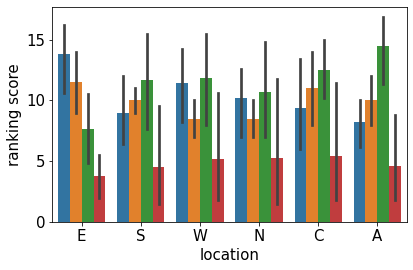

####### finished daily #######
####### start monthly_le #######


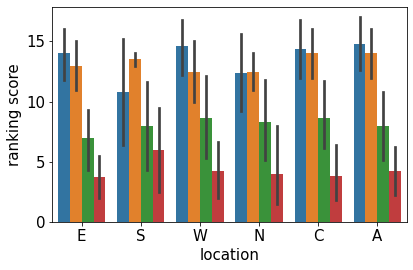

####### finished monthly_le #######
####### start monthly #######


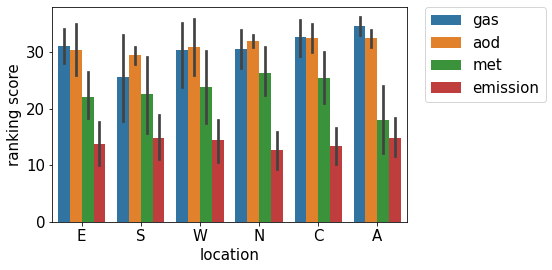

####### finished monthly #######


In [3]:
for time_scale in ["daily","monthly_le","monthly"]:
    print("####### start",time_scale,"#######")
    for gas_flag in ["_gas"]:#,""]:
        df_ls = []
        for spatial_scale in ["r","c","a"]:
            if spatial_scale=="r":
                for loc in ["E","S","W","N"]:
                    model, model_name, feature_ls = load_model(spatial_scale,time_scale,gas_flag,loc)
                    df_tmp = get_ranking(model, model_name, feature_ls,spatial_scale,time_scale,gas_flag,loc)
                    if loc == "E":
                        df = df_tmp.copy()
                    else:
                        df = df.merge(df_tmp, on = "features", how = "outer")
                    del model, model_name, feature_ls, df_tmp
                    gc.collect()
        #         display(df)
                df["category"] = df["features"].map(dd)
                # df.groupby("category").mean().reset_index()
                # qual = df.groupby("category").agg([np.mean, np.std])
                df_plot_tmp = df.set_index(["features","category"]).stack().reset_index()
                df_plot_tmp.columns = ["features","category","region_model","ranking"]
                new = df_plot_tmp["region_model"].str.split("_", expand=True)
                if time_scale == "monthly_le":
                    df_plot_tmp["location"] = new[4].str.upper()
                else:
                    df_plot_tmp["location"] = new[3].str.upper()
                del df, new
                gc.collect()
                    
            else:
                model, model_name, feature_ls = load_model(spatial_scale,time_scale,gas_flag,loc)
                df_plot_tmp = get_ranking(model, model_name, feature_ls,spatial_scale,time_scale,gas_flag,loc)
                df_plot_tmp["category"] = df_plot_tmp["features"].map(dd)
                df_plot_tmp["location"] = spatial_scale.upper()         
                colname = spatial_scale+"_"+time_scale+gas_flag+"_"+model_name
                df_plot_tmp = df_plot_tmp.rename(columns={colname:"ranking"})
                del model, model_name, feature_ls, colname
            # merge    
            df_ls.append(df_plot_tmp[["features","category","location","ranking"]].copy())
            del df_plot_tmp
            gc.collect()
        
        df_plot = pd.concat(df_ls, axis=0)        
        g = sns.barplot(x = "location", y = "ranking", 
                    hue = "category", hue_order=["gas","aod","met","emission"],
                    data=df_plot)
        plt.ylabel("ranking score")
        plt.tight_layout()
        if time_scale=="monthly":
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
#             g._legend.remove()
            g.get_legend().remove()
        plt.show()
        
        df_plot.to_csv("./ranking/"+time_scale+"_all.csv",index=False)
        del df_ls, df_plot
        gc.collect()
    print("####### finished",time_scale,"#######")

## without gas

####### start daily #######


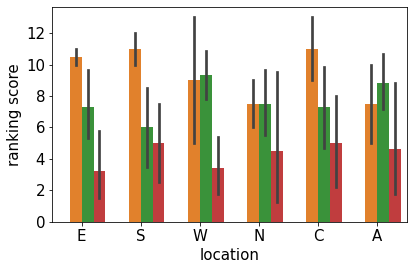

####### finished daily #######
####### start monthly_le #######


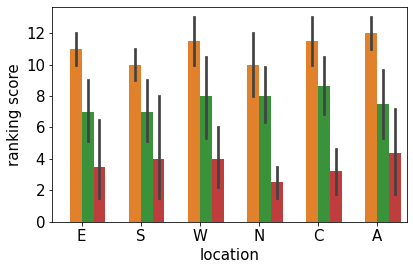

####### finished monthly_le #######
####### start monthly #######


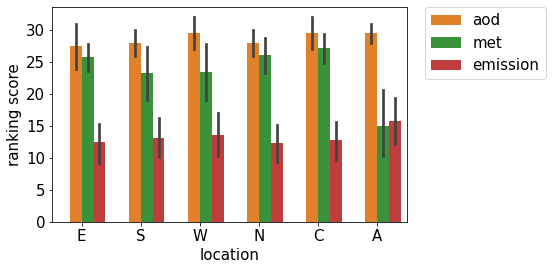

####### finished monthly #######


In [4]:
for time_scale in ["daily","monthly_le","monthly"]:
    print("####### start",time_scale,"#######")
    for gas_flag in [""]:#,""]:
        df_ls = []
        for spatial_scale in ["r","c","a"]:
            if spatial_scale=="r":
                for loc in ["E","S","W","N"]:
                    model, model_name, feature_ls = load_model(spatial_scale,time_scale,gas_flag,loc)
                    df_tmp = get_ranking(model, model_name, feature_ls,spatial_scale,time_scale,gas_flag,loc)
                    if loc == "E":
                        df = df_tmp.copy()
                    else:
                        df = df.merge(df_tmp, on = "features", how = "outer")
                    del model, model_name, feature_ls, df_tmp
                    gc.collect()
        #         display(df)
                df["category"] = df["features"].map(dd)
                # df.groupby("category").mean().reset_index()
                # qual = df.groupby("category").agg([np.mean, np.std])
                df_plot_tmp = df.set_index(["features","category"]).stack().reset_index()
                df_plot_tmp.columns = ["features","category","region_model","ranking"]
                new = df_plot_tmp["region_model"].str.split("_", expand=True)
                if time_scale == "monthly_le":
                    df_plot_tmp["location"] = new[3].str.upper()
                else:
                    df_plot_tmp["location"] = new[2].str.upper()
                del df, new
                gc.collect()
                    
            else:
                model, model_name, feature_ls = load_model(spatial_scale,time_scale,gas_flag,loc)
                df_plot_tmp = get_ranking(model, model_name, feature_ls,spatial_scale,time_scale,gas_flag,loc)
                df_plot_tmp["category"] = df_plot_tmp["features"].map(dd)
                df_plot_tmp["location"] = spatial_scale.upper()         
                colname = spatial_scale+"_"+time_scale+"_"+model_name
                df_plot_tmp = df_plot_tmp.rename(columns={colname:"ranking"})
                del model, model_name, feature_ls, colname
            # merge    
            df_ls.append(df_plot_tmp[["features","category","location","ranking"]].copy())
            del df_plot_tmp
            gc.collect()
        
        df_plot = pd.concat(df_ls, axis=0)        
        g = sns.barplot(x = "location", y = "ranking", 
                    hue = "category", hue_order=["","aod","met","emission"],
                    data=df_plot)
        plt.ylabel("ranking score")
        plt.tight_layout()
        if time_scale=="monthly":
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
#             g._legend.remove()
            g.get_legend().remove()
        plt.show()
        
        df_plot.to_csv("./ranking/"+time_scale+"_wo_gas.csv",index=False)
        del df_ls, df_plot
        gc.collect()
    print("####### finished",time_scale,"#######")